# Entropía Cruzada

Facultad de Ingeniería - Universidad de la República - Uruguay

24 de setiembre de 2025

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pln-fing-udelar/cursos/blob/master/tutoriales/Entropía-Cruzada.ipynb)

En este notebook intentaremos explicar por qué la entropía cruzada es una función de pérdida "natural" para una regresión logística o una red neuronal con salidas que representan una distribución de probabilidad. 

## Una red de ejemplo

Consideremos una red neuronal que, dada una entrada $x^T = (x_1, x_2, \ldots x_n)$, devuelve la distribución de probabilidad para tres clases A, B, y C. Supongamos que tiene una capa oculta, y al final una capa con tres neuronas, a las que se le aplica una función de activación softmax sobre su salida. Nuestra red devolverá, entonces, tres números entre 0 y 1, que suman 1, y que corresponden a las probabilidades de las clases A,B,C respectivamente 

Si, por ejemplo, tenemos tres valores de activación $[z_1,z_2,z_3]$, al aplicar softmax obtendremos: 
$$ 
\text{softmax}([z_1,z_2,z_3])= \left[
\frac{e^{z_1}}{\sum_{i=1}^3 e^{z_i}},\frac{e^{z_2}}{\sum_{i=1}^3 e^{z_i}},\frac{e^{z_3}}{\sum_{i=1}^3 e^{z_i}}] 
\right]
$$

Llamaremos a los $z_i$ _logits_. 

In [1]:
import scipy as sp
import numpy  as np
np.set_printoptions(suppress=True,precision=4)
s = sp.special.softmax([3,2,1])
print("Resultado softmax: {}".format(s))
print("Suma de las probabilidades: {}".format(np.sum(s)))

Resultado softmax: [0.6652 0.2447 0.09  ]
Suma de las probabilidades: 0.9999999999999999


Nuestro ejemplos para entrenar la red serán vectores one-hot, donde el valor 1 indica cuál es la clase correcta. Por ejemplo, si una instancia tiene clase 3, su vector será $[0,0,1]^T$. Llamaremos al i-ésimo ejemplo de entrenamiento $(x^{(i)},y^{(i)})$

## La función de pérdida

Queremos una función de pérdida que:

- Dependa solamente de la salida de mi red, y de cada instancia de entrenamiento
- Pueda calcularse como el promedio de las pérdidas de las diferentes instancias de entrenamiento
- Sea una medida del error cometido por la red

Cuando tengamos esa función, buscaremos los parámetros de la red que la minimicen, utilizando backpropagation y descenso por gradiente (o una variante).

La *entropía cruzada* es esa función de pérdida, y vale:

$$ L(y,\hat{y}) = - \sum_{i=1}^m \sum_{j=1}^C y_{j}^{(i)}\log\hat{y}_{j}^{(i)} $$

siendo $\hat{y}$ el vector de salida de la red, $m$ el número de instancias de entrenamiento y $C$ la cantidad de clases posibles (en nuestro caso, 3). Podemos notar que, para cada instancia, solamente habrá una clase $j$ para la cual el producto no dé 0 (aquel en el que $\hat{y}_{j} =1$).

Por ejemplo, si la salida de nuestra red es $ \hat{y} = [0.2, 0.7, 0.1]^T$ y la instancia de entrenamiento vale $y = [0,1,0]^T$, entonces 

$$ L(y,\hat{y}) = - \log 0.7 = 0.51 $$ 

Puede verse que, si  $ \hat{y}^T = y^T = [0,1,0]$, entonces $ L(y,\hat{y}) = - \log 1 = 0$. También podemos ver que si  $ \hat{y} = y = [0.5,1,0.5]^T$, nuestra función de pérdida no está definida! (en estos casos, las soluciones pasan por hacer clipping de los resultados o utilizar directamente los logits, pero eso va más alla de este tutorial).

Entonces, la pregunta que queremos responder es: *¿por qué elegimos esta función?*

## Meet Claude Shannon

En su artículo "A Mathematical Theory of Communication" Shannon se propuso (entre otras cosas) medir la cantidad de información que da un evento, a partir solamente de su probabilidad de ocurrencia. Supongamos que tenemos un evento con probabilidad $p$ de ocurrir, y queremos que la información (o la sorpresa, o la incertidumbre) de ese evento cumpla ciertas propiedades:

1. $I(p)$ decrece monótonamente con p. Es decir que si p crece, $I(p)$ decrece. Esto tiente sentido: cuanto más improbable es un evento, más nos sorprende que suceda, y tenemos más incertidumbre sobre su ocurrencia. Acertar a rojo en la ruleta no nos parece tan raro como acertar número. 
2. $I(1) = 0$. Si el evento ocurre siempre, no nos da ninguna información, no disminuye en nada nuestra sorpresa.
3. $I(p_1\cdot p_2) = I(p_1) + I(p_2)$ si ambos eventos son independientes, la sorpresa de ver ambos eventos es la suma de las sorpresas de ver cada uno por separado.
4. $I(p)$ es doblemente continua y diferenciable.

Shannon encontró que una función que cumplía esto era $log(1/p) = -log(p)$ (y, de hecho, es la única, a menos de una constante $k$ que lo multiplique). Entonces, cada vez que veamos algo como $-log(p)$, recordemos primero que es lo mismo que $log(1/p)$ y que eso es una medida de la información que nos da el evento. 

Si el logaritmo es en base 2, entonces $I(p)$ son los bits necesarios para representar  $1/p$. Por ejemplo, si $p=1/4$, entonces $I(p)=log(2^2)=2$. Si $p=1/8$, entonces $I(p)=3$, y si $p=1$, entonces $I(p)=0$. 

La función $-log(p)$ luce así: 

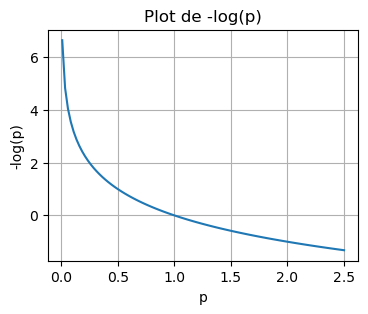

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate some data for p
p = np.linspace(0.01, 2.5, 100) # Avoid log(0)

# Calculate -log2(p)
neg_log_p = -np.log2(p)


# Plot the function using seaborn
plt.figure(figsize=(4, 3))
sns.lineplot(x=p, y=neg_log_p)
plt.xlabel('p')
plt.ylabel('-log(p)')
plt.title('Plot de -log(p)')
plt.grid(True)
plt.show()

### Entropía

Si tenemos una distribución de la probabilidad de los eventos, la _entropía_ es simplemente el promedio ponderado de la información de cada evento, es decir: 

$$ H(p) = \sum_{i=1}^n p_i I(p_i) =  \sum_{i=1}^n p_i log(1/p_i) = \sum_{i=1}^n p_i [- log(p_i)] =  -\sum_{i=1}^n p_i log(p_i)     $$

(y Shannon mostró que es la mínima cantidad de bits en promedio que podemos utilizar para representar los eventos).

La entropía cumple que es 0 si la distribución tiene un $p_i=1$, y es máxima si todos los eventos son equiprobables (y por eso mide que tan "aleatorio" es el conjunto de eventos).

Usemos NumPy para calcular la entropía de la siguiente distribución de probabilidad [1/4, 1/2, 1/8,1/8]:

In [4]:
p = [1/4, 1/2, 1/8, 1/8]
H=-sum(p * np.log2(p))

print("Entropía de p:{}".format(H))
p = [1/4, 1/4, 1/4, 1/4]
H=-sum(p * np.log2(p))
print("Entropía máxima:{}".format(H))


Entropía de p:1.75
Entropía máxima:2.0


Veamos la curva de la entropía cuando solamente tenemos dos eventos

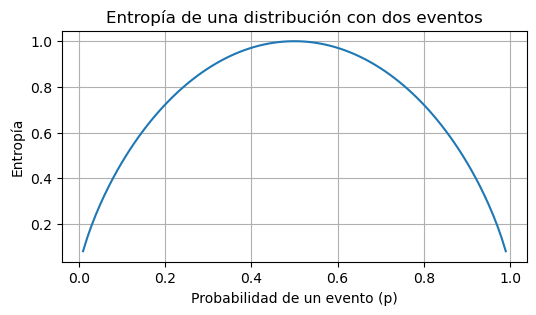

In [8]:
p = np.linspace(0.01, 0.99, 100)  # Avoid log(0) and log(1)


# Calculate entropy for two events: -p*log2(p) - (1-p)*log2(1-p)
entropy = -p * np.log2(p) - (1 - p) * np.log2(1 - p)

# Plot the entropy curve
plt.figure(figsize=(6, 3))
sns.lineplot(x=p, y=entropy)
plt.xlabel('Probabilidad de un evento (p)')
plt.ylabel('Entropía')
plt.title('Entropía de una distribución con dos eventos')
plt.grid(True)
plt.show()

### Entropía Cruzada

Ahora supongamos que _estimamos_ la probabilidad de los eventos, con una distribución $q$ (sabemos que la verdadera es $p$, pero no la conocemos). La información en q será, entonces: $I(q) = -log(q)$. 

La entropía cruzada será el promedio ponderado de la información, calculada con $q$. El asunto es que, para ponderar, utilizamos la distribución verdadera, ya que lo que queremos obtener es el promedio de bits que utilizaremos "en el mundo real", si estimamos la información utilizando $q$ en vez de $p$. Por lo tanto:

$$ H(p,q) =   -\sum_{i=1}^n p_i log(q_i)     $$


Podemos observar que si $p$ y $q$ son iguales, entonces $ H(p,q) = H(p)$.

Ahora supongamos que yo _sé_ que mi clase es $k$. En ese caso, la formula para la entropía cruzada se reduce a: 

$$ H(p,q) =   - log(q_k)     $$

(porque tenemos $p_k =1$ y $p_i =0$ para todo $i\neq k$).

A la diferencia entre la entropía cruzada $H(p,q)$ y $H(p)$ la llamaremos _divergencia de Kullback-Lieber_ o _entropía relativa_, y vale:

$$ D_{K_L}(p||q) =  H(p,q) - H(p) =  -\sum_{i=1}^n p_i log(q_i) + \sum_{i=1}^n p_i log(p_i) = \sum_{i=1}^n p_i(-\log q_i + \log p_i) =  \sum_{i=1}^n p_i \log \frac{p_i}{q_i}$$

### Entropía Cruzada como función de pérdida

Si volvemos a nuestra red neuronal, podemos ver que nuestra función de pérdida es simplemente el promedio de las entropías cruzadas para cada uno de los ejemplos de entrenamiento. 

$$ L(y,\hat{y}) = - \sum_{i=1}^m \sum_{j=1}^C y_{j}^{(i)}\log\hat{y}_{j}^{(i)} $$


Y podemos definirla como el promedio de menos el logaritmo de la probabilidad asignada por la red a la clase correcta, según el conjunto de entrenamiento. Recordando a Shannon, podemos decir que es la "sorpresa" o la incertidumbre que tiene nuestra red sobre la clase correcta: esa sorpresa es mi medida del error (y cuanto más alta sea, mayor será la pérdida). 

Como vimos antes, si mi red le asigna una probabilidad $0.7$ a la clase correcta (para un ejemplo en particular), su loss será $-log(0.7)=0.51$. Si la probabilidad es 1, entonces la pérdida será $-log(1)=0$. Podemos ver que la función de pérdida varía entre 0 y más infinito. 

A la entropía cruzada también se la llama _negative log likelihood loss_. El "negative log" está explicado más arriba. ¿Por qué _likelihood_? 



### Entropia cruzada como función de verosimilitud

En probabilidad, la función de verosimilitud (en inglés, _likelihood_) mide, a partir de una muestra, la probabilidad de ver esos datos en función de los parámetros del modelo. En nuestro caso, nuestro modelo es la red, y lo que queremos son los parámetros que maximizan la probabilidad $p(y=k|x)$, siendo $k$ la clase correcta (según nuestra instancia de entrenamiento). Sabemos (por ser los ejemplos one-hot) que: 

$$ p(y|x;\text{modelo}) = \hat{y}_k$$

La verosimilitud (asumiendo independencia entre las instancias) será el producto de las probabilidades individuales:

$$ L = \prod_{i=1}^m \prod_{j=1}^C (\hat{y}_j^{(i)})^{y_{j}^{(i)}} $$

(Para ser exactos, estamos calculando una verosimilitud _condicional_, porque el valor depende de los parámetros del modelo,  condicionado a la entrada $x$).

Si tomamos logaritmos, nuestra productoria se convierte en una sumatoria, y los exponentes pasan a multiplicar los valores de la información (i.e. los logaritmos)

$$ LL = \sum_{i=1}^m \sum_{j=1}^C y_{j}^{(i)} \log(\hat{y}_j^{(i)}) $$

Como queremos minimizar en vez de maximizar, multiplicamos todo por (-1) y obtenemos:

$$ NLL = - \sum_{i=1}^m  \sum_{j=1}^C y_{j}^{(i)} \log(\hat{y}_j^{(i)}) $$

Que es exactamente nuestra función de pérdida!







### ¿Y la regresión logística? 

Con todo lo explicado antes, la regresión logística es solamente un caso particular, donde tenemos dos clases, y cambiamos un poco el comportamiento de la red: ahora, tenemos una sola neurona de salida que nos da la probabilidad de la clase positiva (y, por lo tanto, asumiendo que la probabilidad de la clase negativa sera 1 menos ese valor). Entonces, la entropía cruzada cambia a esta fórmula, que es exactamente igual a la anterior:

$$ L(y,\hat{y}) = - \sum_{i=1}^m \sum_{j=1}^C y_{j}^{(i)}\log\hat{y}_{j}^{(i)} = \sum_{i=1}^m y'^{(i)}\log\hat{y'}^{(i)} + (1 - y'^{(i)})\log(1-\hat{y'}^{(i)}) $$

(Hemos llamado $y'$ al valor la clase positiva, y $\hat{y'}$ a la salida de la red)


### La función de costo Entropía Cruzada en PyTorch

En PyTorch, la pérdida por entropía cruzada admite dos formas distintas para aplicarla. Con lo que vimos antes, debería ser claro su uso.

La primera es `torch.nn.CrossEntropyLoss`: esta función computa la entropía cruzada partiendo de los _logits_ (i.e. los valores antes de hacer softmax). Los ejemplos de entrenamiento pueden tener un índice de clase, o una distribución de probabilidad sobre las clases. 



In [53]:
import torch
from torch import nn
import scipy as sp

# Example of target with class indices
loss = nn.CrossEntropyLoss()

# Salida de la red (sin aplicar softmax), en este caso tenemos 3 instancias de 5 clases cada una 
#input = torch.randn(3, 5, requires_grad=True) # Target tiene la clase de cada instancia
input = torch. tensor([[ 0.7896, -1.3428,  0.4499, -0.4486, -1.8486],
        [-2.1771,  0.5159,  1.4877, -1.6626, -0.6794],
        [ 0.3828, -1.1884,  2.0914,  1.9666,  0.5588]], requires_grad=False)
target = torch.tensor([1,3,4])
output = loss(input, target)

print(output)


# Verificamos las cuentas. Lo hago caso a caso para que quede bien clarito.
instancia1 = input[0].numpy()
instancia2 = input[1].numpy()
instancia3 = input[2].numpy()

# Hago el softmax de cada instancia
soft1 = sp.special.softmax(instancia1)
soft2 = sp.special.softmax(instancia2)
soft3 = sp.special.softmax(instancia3)

# Calculo, para cada instancia el -log de la clase "correcta"
loss1 = -np.log(soft1[1])
loss2 = -np.log(soft2[3])
loss3 = -np.log(soft3[4])

print (np.mean([loss1,loss2,loss3]))




tensor(2.9620)
2.9620287


Reproduzcamos el caso en el que los ejemplos son one hot:

In [60]:
# La salida de la red es la misma que en el caso anterior, son los logits.
input = torch. tensor([[ 0.7896, -1.3428,  0.4499, -0.4486, -1.8486],
        [-2.1771,  0.5159,  1.4877, -1.6626, -0.6794],
        [ 0.3828, -1.1884,  2.0914,  1.9666,  0.5588]], requires_grad=False)

# Construimos un vector one-hot. La pérdida debería ser la misma que en el caso anterior. 
# Esto también podría ser una distribución de probabilidad.
target = torch.tensor([[0,1,0,0,0],[0,0,0,1,0],[0,0,0,0,1]], dtype=torch.float)
output = loss(input, target)
print(output)

tensor(2.9620)


Una forma alternativa de calcular lo mismo es meter el softmax en la red, y utilizar `torch.nn.NLLLoss`, que asume que la entrada son los logaritmos de las probabilidades (es decir, el resultado de agregar una capa `LogSoftmax` en la red). 